In [44]:
import re
import linecache         as lc
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

from astropy                  import units
from astropy.coordinates      import SkyCoord
from astropy.io               import fits
from astropy.wcs              import WCS
from astropy.visualization    import ZScaleInterval
from kapteyn                  import kmpfit
from matplotlib.ticker        import MultipleLocator, FormatStrFormatter

from global_functions_library import plot_image, make_mask_and_compute_background_statistics, do_aperture_photometric_by_radius, compute_instrumental_magnitude_and_error, color_term_fitting, residual_function

In [45]:
def FIND_SS_FROM_SEXTRACTOR_CATALOG(filter: str, object_name: str) -> tuple :
    source_sex_catalog     = "./SEXTRACTOR_CATALOG/detected_sources_%s_%s_band.cat"%(object_name,filter)
    skip_row_num           = 20
    column_dict            = {}
    column_namelist        = []

    for row_num in range(1, skip_row_num+1):
        column_dict[np.int32(lc.getline(source_sex_catalog, row_num).split()[1])] = lc.getline(source_sex_catalog , row_num).split()[2] # read the column information
        # print(lc.getline(source_sex_catalog, row_num))

    data_frame_source_sex  = pd.read_csv(source_sex_catalog, skiprows=skip_row_num, delimiter="\s+", header=None)

    for column_num in range(1, data_frame_source_sex.shape[1]+1):
        try:    column_namelist.append(column_dict[column_num])
        except: column_namelist.append("NONE")
    data_frame_source_sex.columns = column_namelist

    star_sex_criteria   = 0.5
    star_sex_filter     = (data_frame_source_sex["CLASS_STAR"]>star_sex_criteria)

    star_sex_pixel_x    = data_frame_source_sex["X_IMAGE"][star_sex_filter]
    star_sex_pixel_y    = data_frame_source_sex["Y_IMAGE"][star_sex_filter]
    star_sex_index      = data_frame_source_sex["NUMBER"] [star_sex_filter]
    data_frame_final    = data_frame_source_sex[star_sex_filter]
    return data_frame_final, star_sex_pixel_x, star_sex_pixel_y

In [46]:
import astropy
import pandas

def BUILD_LANDOLT_CATALOG() -> pd.DataFrame:
    df_column = ["Star" ,"RA2000", "DEC2000", "V", "B-V", "U-B", "V-R", "R-I", "V-I"]
    df_data   = [["114 531", "22:40:37", "+00:51:49", 12.09,  0.733,  0.186,  0.422,  0.403,  0.825],
                 ["114 637", "22:40:43", "+01:03:02", 12.07,  0.801,  0.307,  0.456,  0.415,  0.872],
                 ["114 446", "22:41:04", "+00:45:56", 12.06,  0.737,  0.237,  0.397,  0.369,  0.769],
                 ["114 654", "22:41:26", "+01:10:03", 11.83,  0.656,  0.178,  0.368,  0.341,  0.711],
                 ["114 656", "22:41:35", "+01:11:01", 12.64,  0.965,  0.698,  0.547,  0.506,  1.051],
                 ["114 548", "22:41:37", "+00 58 59", 11.60,  1.362,  1.573,  0.738,  0.651,  1.387],
                 ["114 750", "22:41:45", "+01:12:30", 11.92, -0.041, -0.354,  0.027, -0.015,  0.011],
                 ["114 670", "22:42:10", "+01:10:09", 11.10,  1.206,  1.223,  0.645,  0.561,  1.208],
                 ["114 176", "22:43:11", "+00:21:09",  9.24,  1.485,  1.853,  0.800,  0.717,  1.521]]
    for col in range(len(df_column)):
        ra_dec_decimal = SkyCoord("%s %s"%(df_data[col][1],df_data[col][2]), unit=(units.hourangle, units.deg), frame='icrs').to_string('decimal')
        ra, dec = tuple(np.float64(x) for x in ra_dec_decimal.split(" "))
        df_data[col][1]      = ra
        df_data[col][2]      = dec
    data_frame_landolt = pd.DataFrame(df_data, columns=df_column)
    star_landolt_world_ra    = data_frame_landolt["RA2000"]
    star_landolt_world_dec   = data_frame_landolt["DEC2000"]
    
    star_landolt_world_coord = np.concatenate((star_landolt_world_ra.values.reshape(-1,1), star_landolt_world_dec.values.reshape(-1,1)), axis=1)
    star_landolt_index       = data_frame_landolt.index
    return data_frame_landolt, star_landolt_index, star_landolt_world_coord

def FIND_SS_FROM_LANDOLT_CATALOG(star_landolt_index: pandas.core.indexes.range.RangeIndex, star_landolt_world_coord: np.array, imag_data: np.array, wcs: astropy.wcs.wcs.WCS) -> tuple:
    left_edge_world           = wcs.all_pix2world([[0,0]], 0)[0]
    right_edge_world          = wcs.all_pix2world([[imag_data.shape[1],imag_data.shape[0]]], 0)[0]
    star_landolt_world_ra     = star_landolt_world_coord[:,0]
    star_landolt_world_dec    = star_landolt_world_coord[:,1]
    star_landolt_filter       = (star_landolt_world_ra >left_edge_world[0]) & (star_landolt_world_ra <right_edge_world[0]) & \
                                (star_landolt_world_dec<left_edge_world[1]) & (star_landolt_world_dec>right_edge_world[1])  # left_edge_ra < right_edge_ra ; left_edge_dec > right_edge_dec

    star_landolt_pixel_coord  = wcs.all_world2pix(star_landolt_world_coord[star_landolt_filter], 0)
    star_landolt_pixel_x      = star_landolt_pixel_coord[:,0]
    star_landolt_pixel_y      = star_landolt_pixel_coord[:,1]
    star_landolt_index        = star_landolt_index[star_landolt_filter]
    
    star_landolt_pixel_x        = pd.Series(star_landolt_pixel_x, index=star_landolt_index)
    star_landolt_pixel_y        = pd.Series(star_landolt_pixel_y, index=star_landolt_index)
    
    return star_landolt_index, star_landolt_pixel_x, star_landolt_pixel_y

In [47]:
file_path_dict                           = {"R": "/home/koarakawaii/Lecture_Code/Advanced_Astronomical_Observation/Term_Project/image_processing/FITS_SDSS_Elliptical_Galaxy/standard_star_SA114_corrected/R/plate_solving/SA114_R_10sec_stacked_plate_solved.fit",
                                            "I": "/home/koarakawaii/Lecture_Code/Advanced_Astronomical_Observation/Term_Project/image_processing/FITS_SDSS_Elliptical_Galaxy/standard_star_SA114_corrected/I/plate_solving/SA114_I_20sec_stacked_plate_solved.fit"}
object_name                              = "SA114"

data_frame_landolt,\
    star_landolt_index,\
        star_landolt_world_coord         = BUILD_LANDOLT_CATALOG()

imag_header_dict                         = {}
imag_data_dict                           = {}
imag_wcs_dict                            = {}
data_frame_sex_dict                      = {}
star_landolt_pixel_x_dict                  = {}
star_landolt_pixel_y_dict                  = {}
landolt_to_sex_index_mapping_filter_dict   = {}

for band_filter in ["R","I"]:
    fits_file_path = file_path_dict[band_filter]
    with fits.open("%s"%(fits_file_path)) as hdul:
        imag_header             = hdul[0].header 
        imag_data               = hdul[0].data
    
    wcs                         = WCS(imag_header)
    
    # find standard stars from SEXTRACTOR and LANDOLT CATALOG
    data_frame_sex, star_sex_pixel_x, star_sex_pixel_y                      = FIND_SS_FROM_SEXTRACTOR_CATALOG(filter=band_filter, object_name=object_name)
    star_landolt_index_filtered, star_landolt_pixel_x, star_landolt_pixel_y = FIND_SS_FROM_LANDOLT_CATALOG(star_landolt_index=star_landolt_index, star_landolt_world_coord=star_landolt_world_coord, imag_data=imag_data, wcs=wcs)
    
    # matching the standard stars position from SEXTRACTOR and LANDOLT
    distance_min_criteria       = 100                                    # distance difference must be smaller than 10 pixel size to judge as matching
    # flux_auto_criteria          = 10.0*data_frame_sex["FLUX_AUTO"].max() # FLUX_AUTO msut within 0.1*maximum FLUX_AUTO value 
    landolt_to_sex_index_map_dict = {}
    star_sex_pixel_x_copy       = star_sex_pixel_x.copy()
    star_sex_pixel_y_copy       = star_sex_pixel_y.copy()

    for landolt_idx in star_landolt_index_filtered:
        distance                = ((star_sex_pixel_x_copy-star_landolt_pixel_x[landolt_idx])**2.0 + (star_sex_pixel_y_copy-star_landolt_pixel_y[landolt_idx])**2.0)**0.5
        sex_idx                 = distance.index[distance.argmin()]
        # pass standard stars whose position cannot be matched
        if   distance[sex_idx] > distance_min_criteria:
            print("Standard star with LANDOLT index %d cannot be matched for filter %s"%(landolt_idx, band_filter))
        # # pass standard stars whose brightness is too high
        # elif data_frame_sex["FLUX_AUTO"][sex_idx] > flux_auto_criteria:
        #     print("Standard star with LANDOLT index %d is too bright for filter %s"%(landolt_idx, band_filter))
        else:
            landolt_to_sex_index_map_dict[landolt_idx] = sex_idx
        
        star_sex_pixel_x_copy.drop(labels=[sex_idx])
        star_sex_pixel_y_copy.drop(labels=[sex_idx])    

    imag_header_dict[band_filter]                         = imag_header
    imag_data_dict[band_filter]                           = imag_data
    imag_wcs_dict[band_filter]                            = wcs
    data_frame_sex_dict[band_filter]                      = data_frame_sex
    star_landolt_pixel_x_dict[band_filter]                = star_landolt_pixel_x
    star_landolt_pixel_y_dict[band_filter]                = star_landolt_pixel_y
    landolt_to_sex_index_mapping_filter_dict[band_filter] = landolt_to_sex_index_map_dict
    
    print("Filer=%s"%band_filter)
    print("======================================================================================================")
    for index, landolt_idx in enumerate(landolt_to_sex_index_map_dict):
        print("\tMatching object #%d"%index)
        print("\t\tStandard star SEXTRACTOR pixel_x = %.4f, pixel_y = %.4f ."%(star_sex_pixel_x[landolt_to_sex_index_map_dict[landolt_idx]], star_sex_pixel_y[landolt_to_sex_index_map_dict[landolt_idx]]))
        print("\t\tStandard star LANDOLT pixel_x = %.4f; pixel_y = %.4f ."%(star_landolt_pixel_x[landolt_idx], star_landolt_pixel_y[landolt_idx]))
    

Filer=R
	Matching object #0
		Standard star SEXTRACTOR pixel_x = 1185.9232, pixel_y = 3240.9116 .
		Standard star LANDOLT pixel_x = 1196.3113; pixel_y = 3263.0973 .
	Matching object #1
		Standard star SEXTRACTOR pixel_x = 2639.3337, pixel_y = 2302.7864 .
		Standard star LANDOLT pixel_x = 2628.2384; pixel_y = 2319.5228 .
	Matching object #2
		Standard star SEXTRACTOR pixel_x = 2935.2383, pixel_y = 2170.2488 .
		Standard star LANDOLT pixel_x = 2932.1537; pixel_y = 2189.7546 .
	Matching object #3
		Standard star SEXTRACTOR pixel_x = 2998.2312, pixel_y = 3780.3347 .
		Standard star LANDOLT pixel_x = 3001.1704; pixel_y = 3794.3724 .
	Matching object #4
		Standard star SEXTRACTOR pixel_x = 3254.7317, pixel_y = 1977.9935 .
		Standard star LANDOLT pixel_x = 3259.3319; pixel_y = 1991.2009 .
	Matching object #5
		Standard star SEXTRACTOR pixel_x = 4075.6599, pixel_y = 2285.3906 .
		Standard star LANDOLT pixel_x = 4104.6363; pixel_y = 2301.5517 .
Filer=I
	Matching object #0
		Standard star SEXTRA

In [48]:
# find the filter with the least number of standard stars
filter_with_least_star = list(landolt_to_sex_index_mapping_filter_dict.keys())[np.argmin(np.array([len(dict_x) for dict_x in landolt_to_sex_index_mapping_filter_dict.values()]))]
filter_rest            = list(landolt_to_sex_index_mapping_filter_dict.keys())
filter_rest.remove(filter_with_least_star)

# drop standard stars with landolt index not found in other filters
landolt_idx_cached = np.array(list(landolt_to_sex_index_mapping_filter_dict[filter_with_least_star].keys()))
for landolt_idx in landolt_idx_cached:
    for band_filter in filter_rest:
        if landolt_idx not in landolt_to_sex_index_mapping_filter_dict[band_filter].keys():
            del(landolt_to_sex_index_mapping_filter_dict[filter_with_least_star][landolt_idx])

# make new landolt->sextractor index dictionary for common indices for all the rest filters           
common_landolt_idx = landolt_to_sex_index_mapping_filter_dict[filter_with_least_star].keys()
for band_filter in filter_rest:
    sex_idx_correspond_to_common_landolt_idx = [landolt_to_sex_index_mapping_filter_dict[band_filter][landolt_idx] for landolt_idx in common_landolt_idx]
    landolt_to_sex_index_mapping_filter_dict[band_filter] = dict(zip(common_landolt_idx, sex_idx_correspond_to_common_landolt_idx))

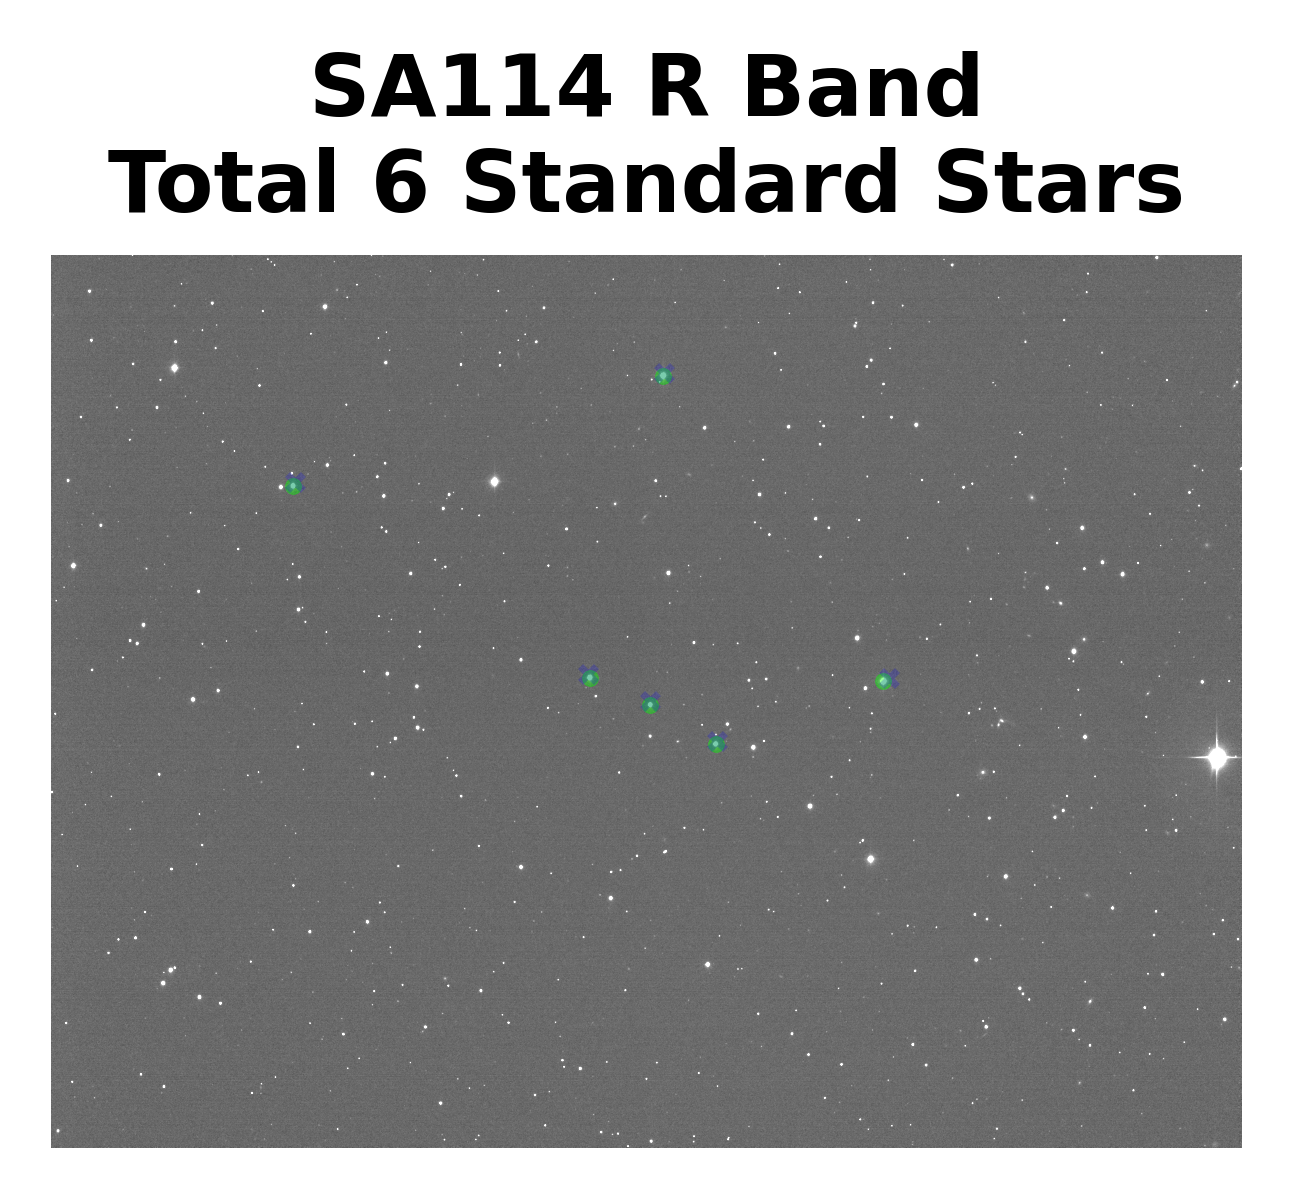

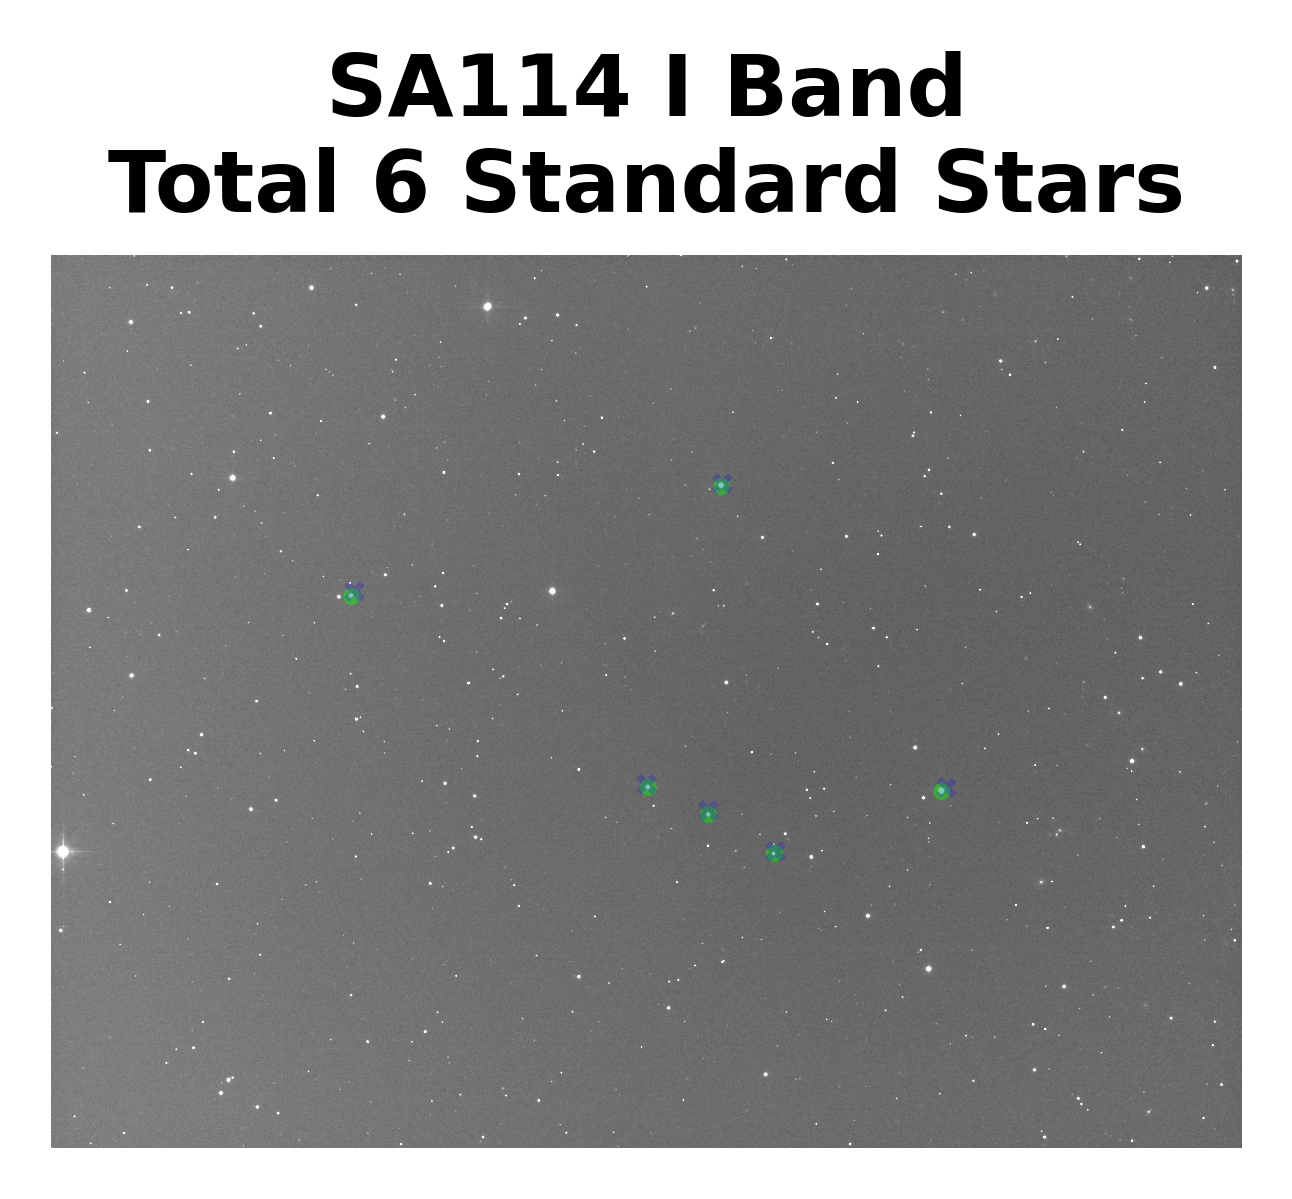

In [49]:
dpi            = 512
save_file_path = "./photo_gallery"

for band_filter in ["R","I"]:
    v_min, v_max                  = ZScaleInterval().get_limits(values=imag_data_dict[band_filter])
    star_sex_pixel_x              = data_frame_sex_dict[band_filter]["X_IMAGE"]
    star_sex_pixel_y              = data_frame_sex_dict[band_filter]["Y_IMAGE"]
    star_landolt_pixel_x          = star_landolt_pixel_x_dict[band_filter]
    star_landolt_pixel_y          = star_landolt_pixel_y_dict[band_filter]
    landolt_to_sex_index_map_dict = landolt_to_sex_index_mapping_filter_dict[band_filter]
    
    save_fig_name                 = "standard_stars_%s_snapshot_%s_band.png"%(object_name, band_filter)
    fig                           = plt.figure(figsize=(3,3), dpi=dpi)
    ax                            = plt.subplot(111)
    plot_image(ax=ax, image_array=imag_data_dict[band_filter], v_min=v_min, v_max=v_max, cmap="gray", norm_type="log", title="%s %s Band\nTotal %d Standard Stars"%(object_name,imag_header_dict[band_filter]["FILTER"], len(landolt_to_sex_index_map_dict)))

    ax.scatter(star_sex_pixel_x[landolt_to_sex_index_map_dict.values()], star_sex_pixel_y[landolt_to_sex_index_map_dict.values()], s=5.0, edgecolors=None, color="lime", marker="o", alpha=0.4, linewidths=0.1)        # SEXTRACTOR stars
    ax.scatter(star_landolt_pixel_x[landolt_to_sex_index_map_dict.keys()], star_landolt_pixel_y[landolt_to_sex_index_map_dict.keys()], s=5.0, edgecolors=None, color="blue",    marker="x", alpha=0.2, linewidths=1.0) # SEXTRACTOR stars
    plt.savefig("%s/%s"%(save_file_path,save_fig_name), bbox_inches='tight', dpi=dpi, pad_inches=0.02, facecolor='white', transparent=True)

R Band Standard Star with APASS Index 1 ....
Aperture radius = 7.74:
	Pixel counts in the aperture mask is 185 .
	Total Brightness within the aperture mask is 1.5465e-01 ± 3.2400e-04 UNIT .
----------------------------------------------------------------------------------------------------
	FLUX_AUTO by SEXTRACTOR is 1.5760e-01 ± 4.1186e-05 UNIT
----------------------------------------------------------------------------------------------------
R Band Standard Star with APASS Index 3 ....
Aperture radius = 9.62:
	Pixel counts in the aperture mask is 292 .
	Total Brightness within the aperture mask is 1.8122e-01 ± 3.2493e-04 UNIT .
----------------------------------------------------------------------------------------------------
	FLUX_AUTO by SEXTRACTOR is 1.8262e-01 ± 4.6857e-05 UNIT
----------------------------------------------------------------------------------------------------
R Band Standard Star with APASS Index 4 ....
Aperture radius = 9.89:
	Pixel counts in the aperture mas

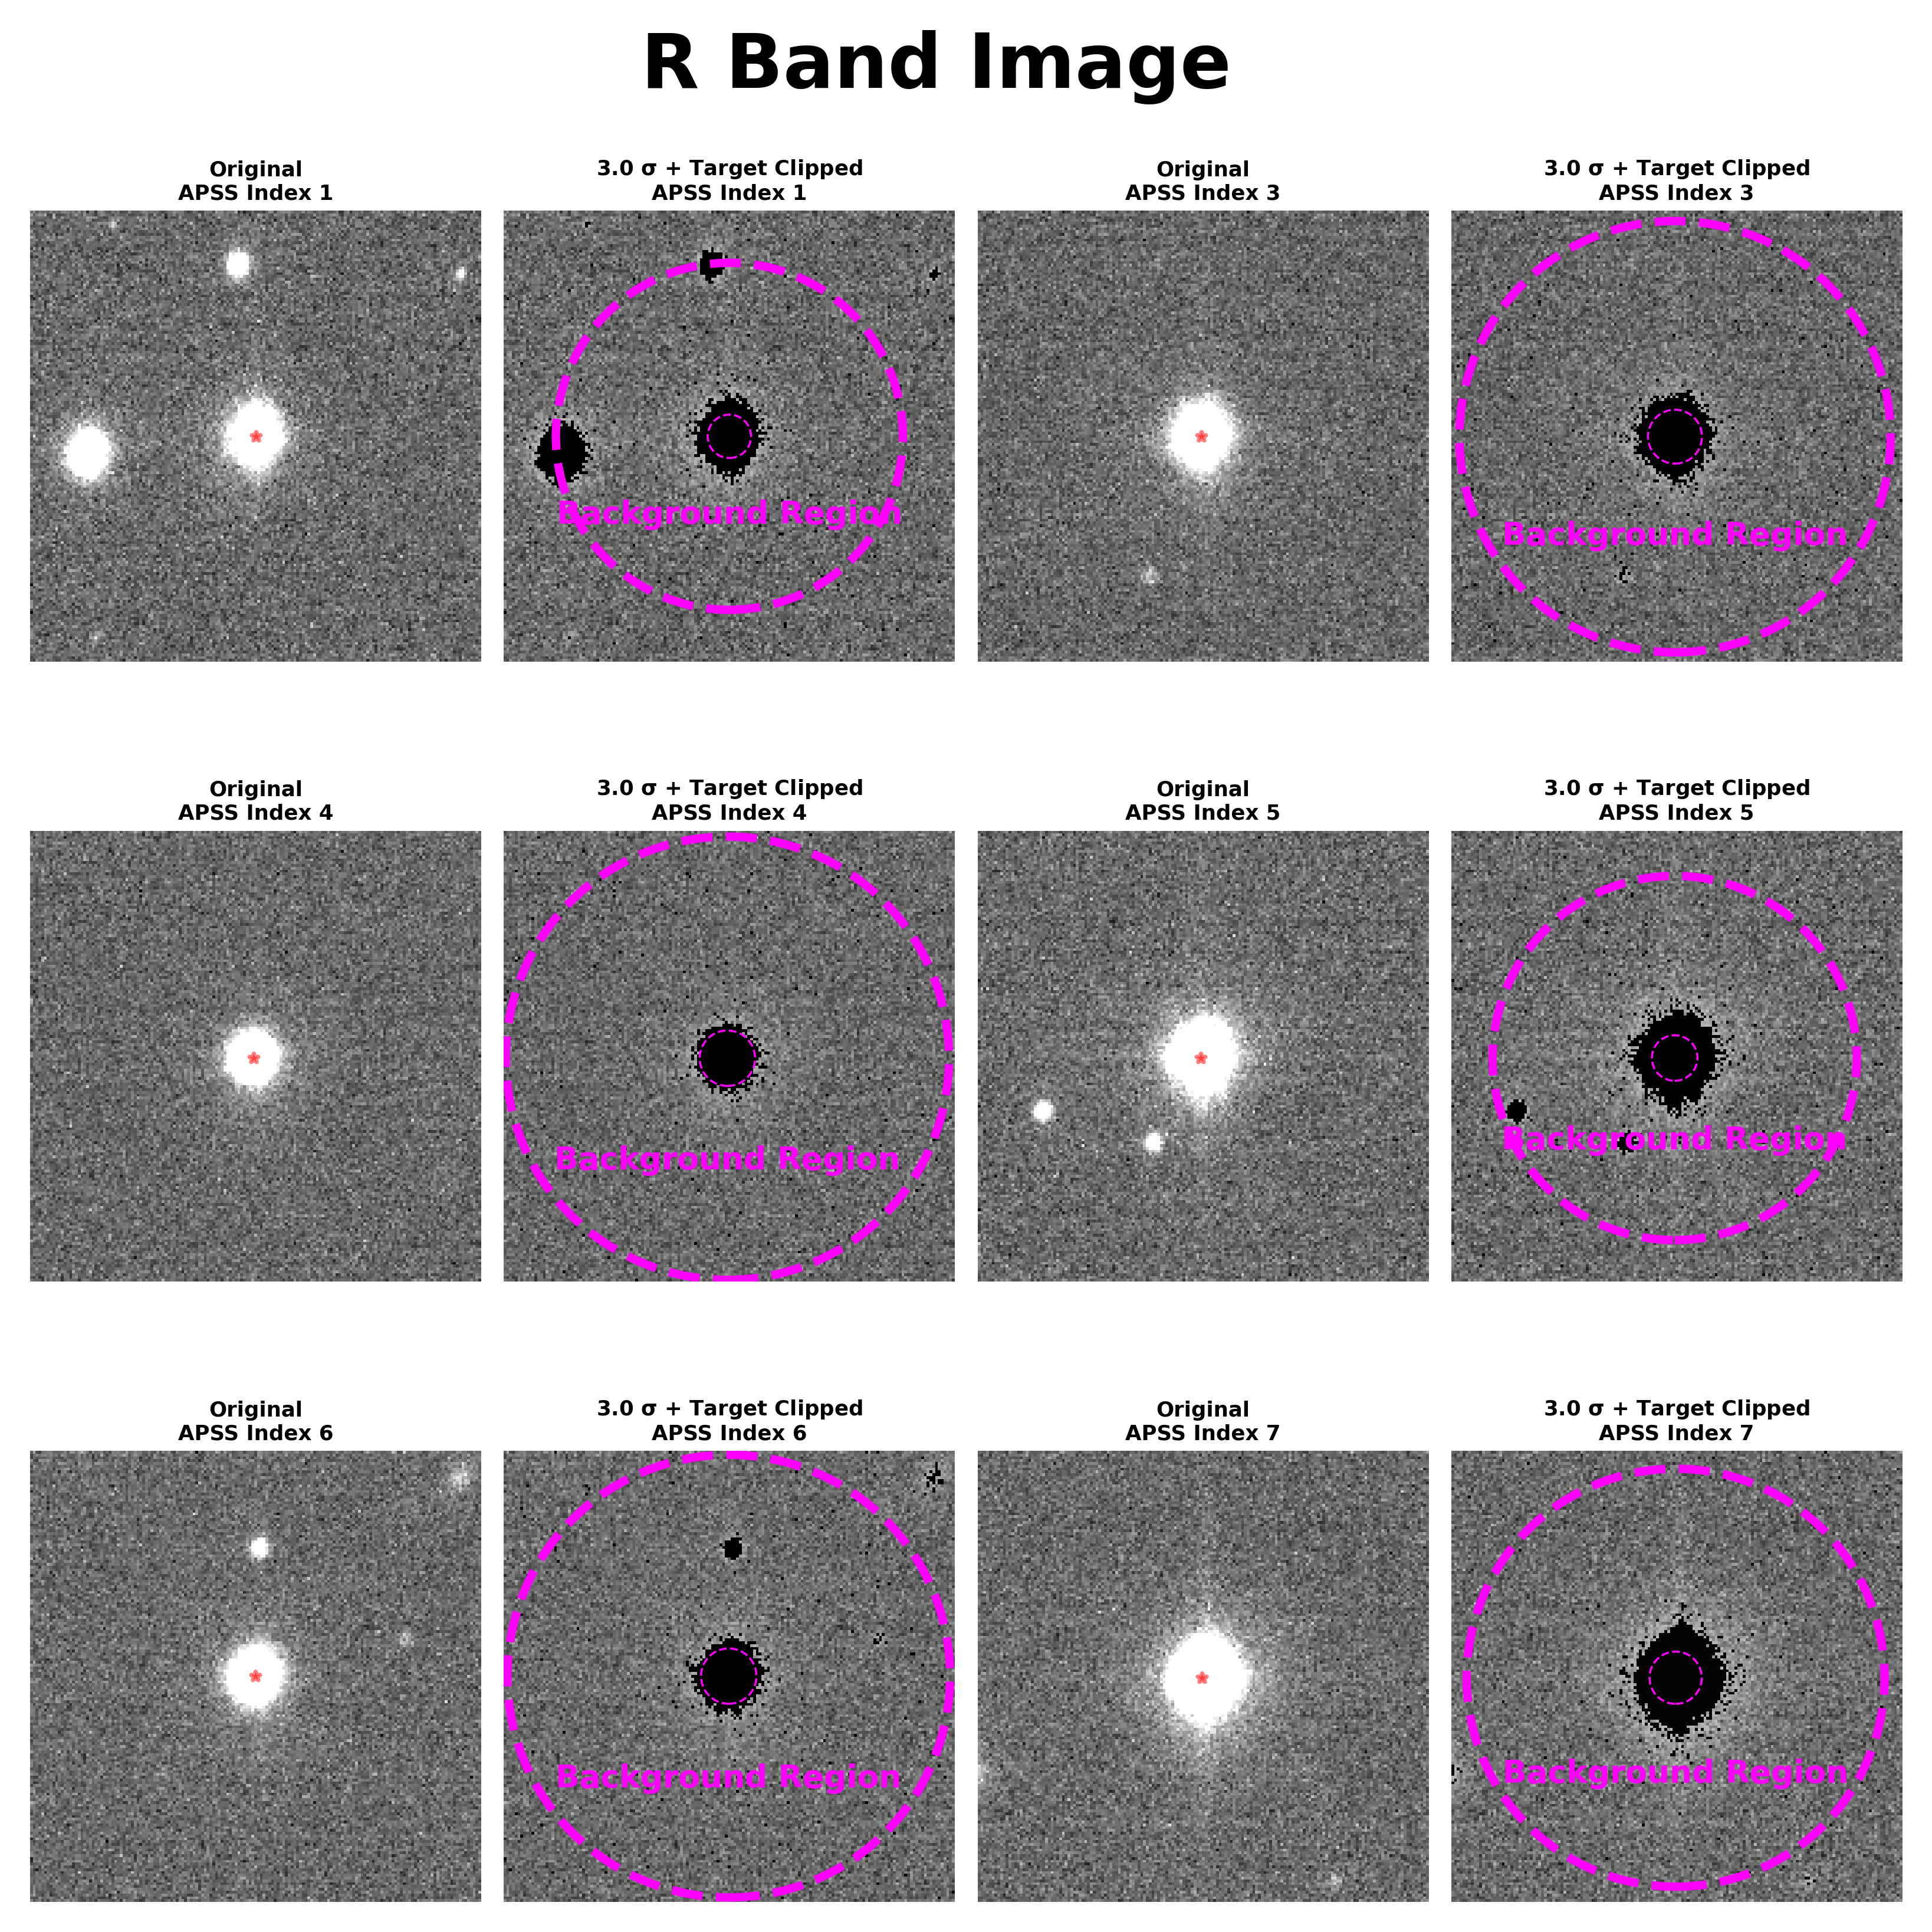

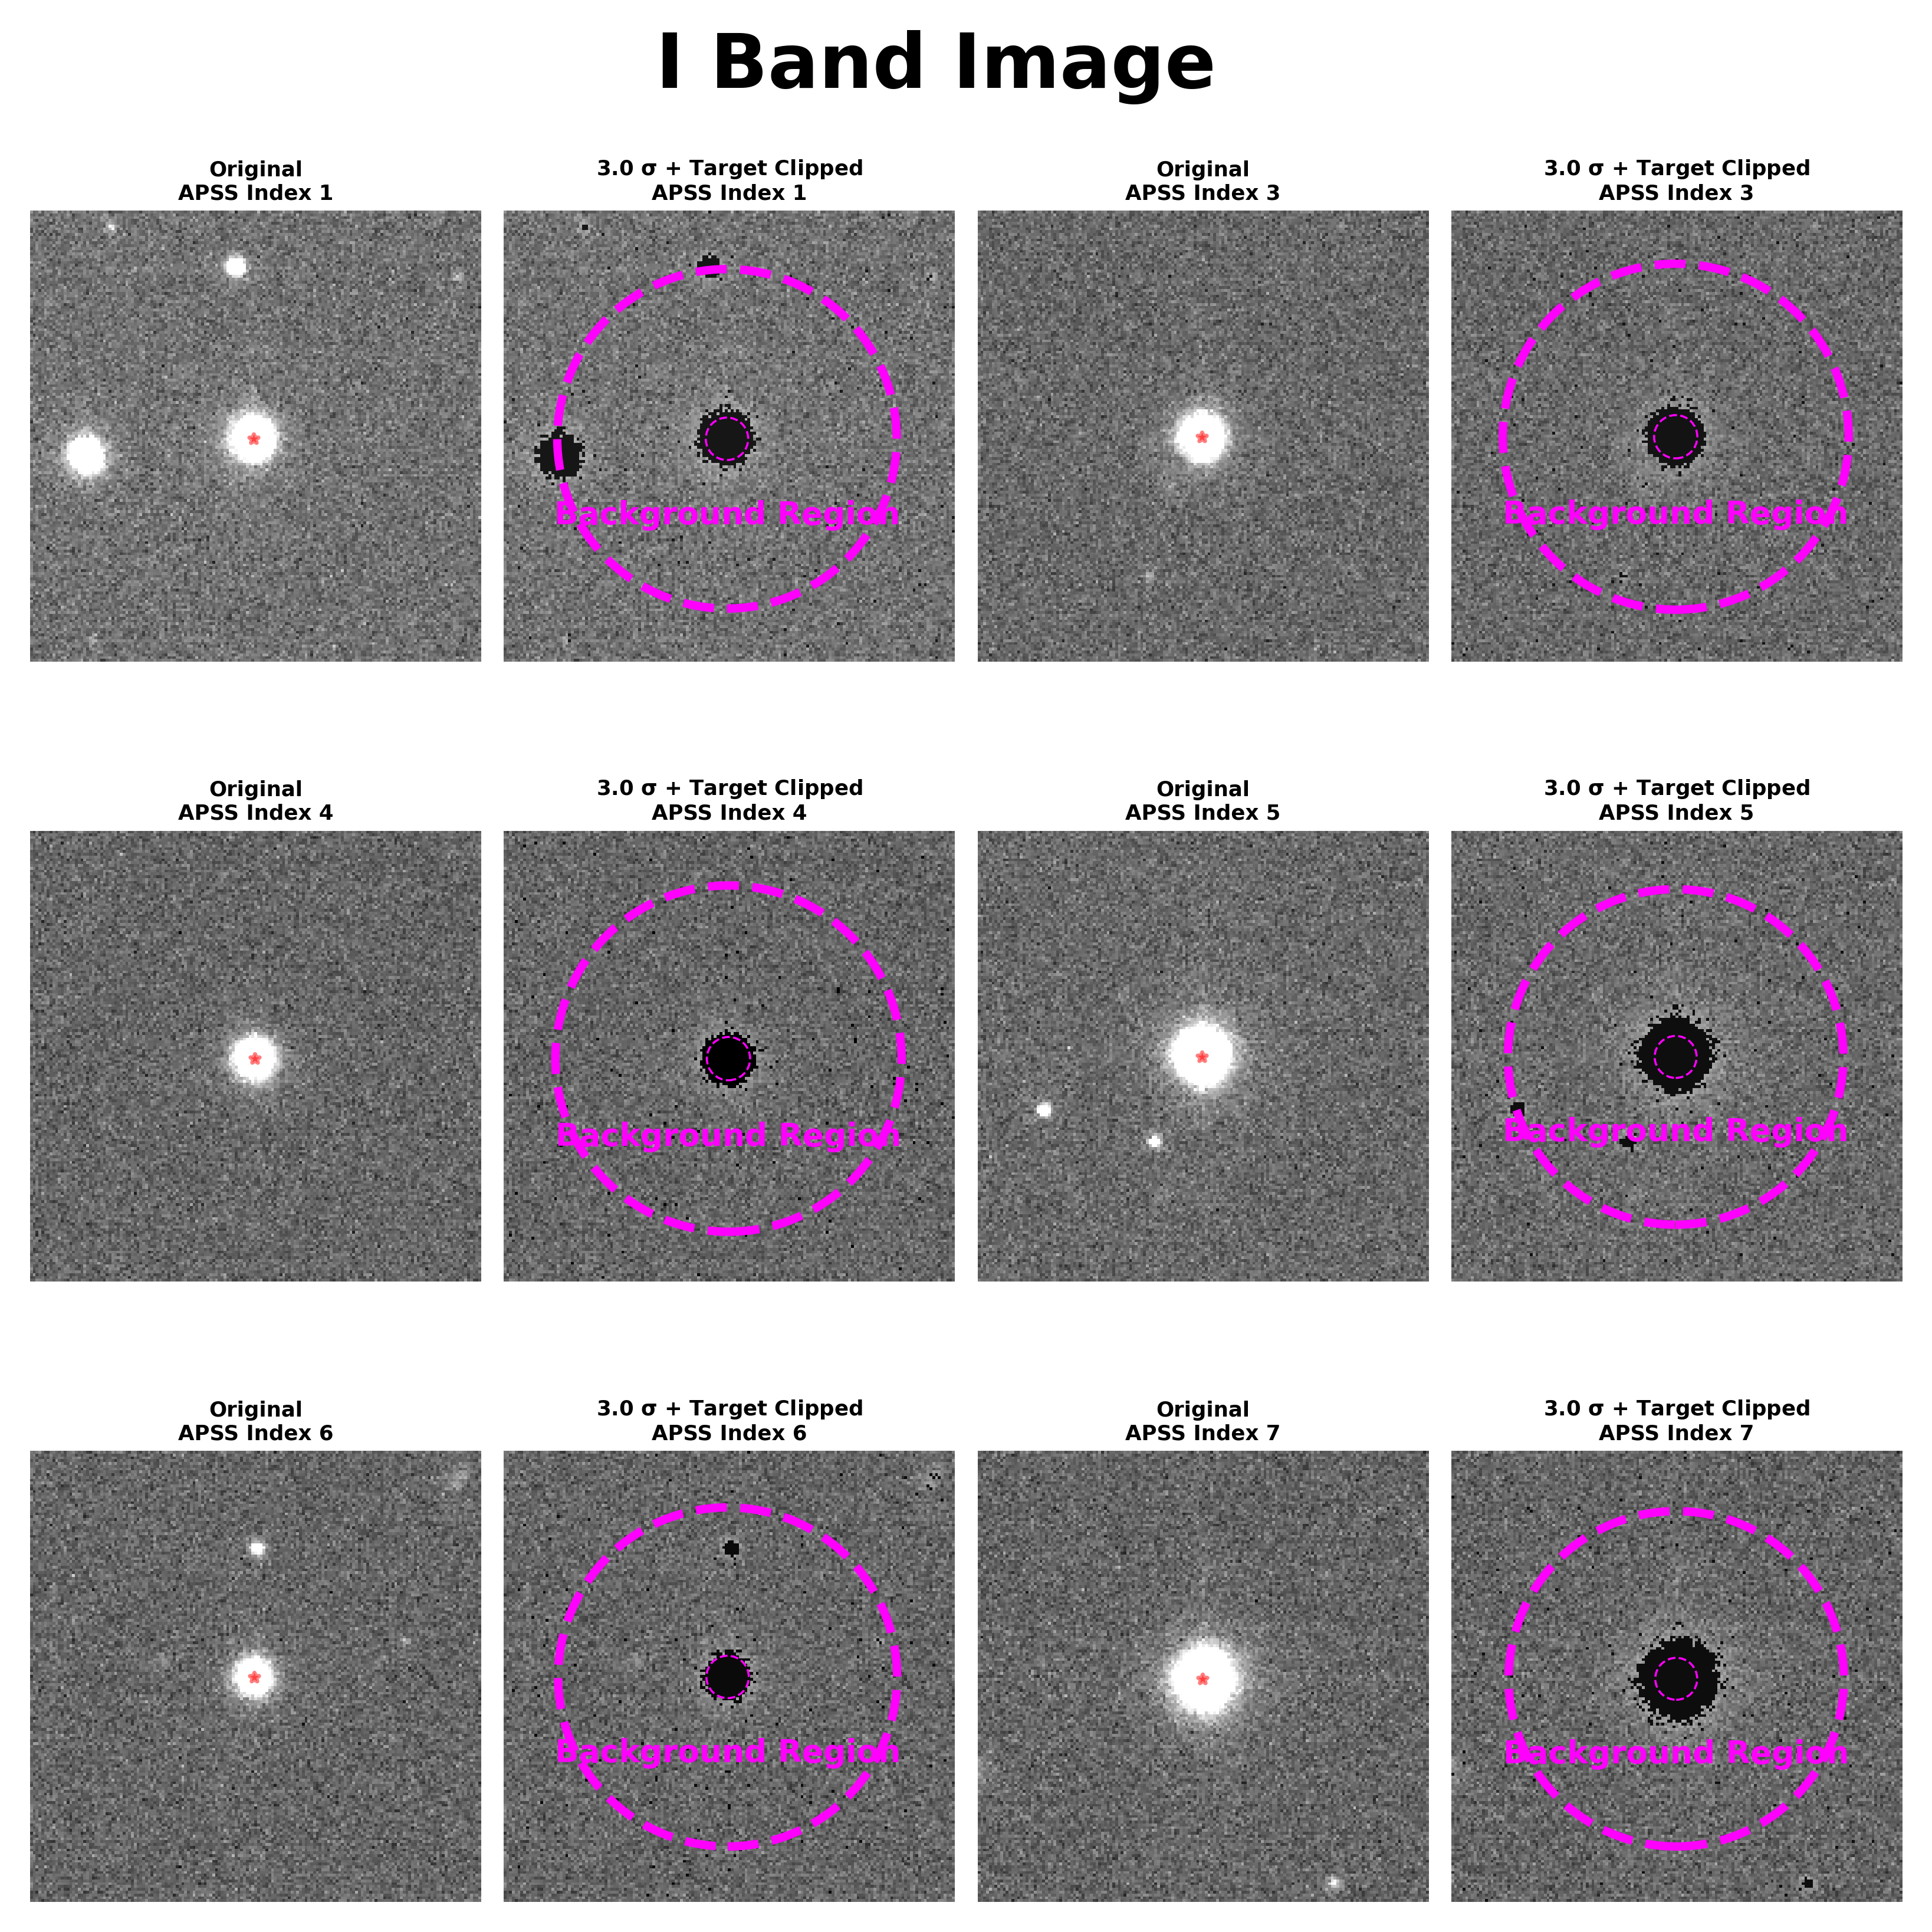

In [50]:
how_many_sigma                                   = 3.0
max_iter_criteria                                = 10
crop_size                                        = 80
dpi                                              = 512
aperture_max                                     = 6.0 # in unit of arcsec
n_row                                            = 3
n_col                                            = 4
save_file_path                                   = "./photo_gallery"
aperture_mask_filter_dict                        = {"R":{}, "I":{}}
aperture_pixel_count_filter_dict                 = {"R":{}, "I":{}}
brightness_sum_within_aperture_filter_dict       = {"R":{}, "I":{}}
brightness_sum_error_within_aperture_filter_dict = {"R":{}, "I":{}}

for band_filter in ["R","I"]:
    landolt_to_sex_index_map_dict            = landolt_to_sex_index_mapping_filter_dict[band_filter]
    imag_data                                = imag_data_dict[band_filter]
    star_sex_pixel_x                         = data_frame_sex_dict[band_filter]["X_IMAGE"]
    star_sex_pixel_y                         = data_frame_sex_dict[band_filter]["Y_IMAGE"]
    pixel_angle                              = np.rad2deg(imag_header_dict[band_filter]["XPIXSZ"]*1e-3/imag_header_dict[band_filter]["FOCALLEN"])*3600.  # arcsec per pixel
    object_circle_radius_max                 = (0.5*aperture_max)/pixel_angle # convert to number of of pixel
    save_fig_name                            = "standard_stars_gallery_%s_band.png"%(band_filter)
    
    # plotting
    v_min, v_max                             = ZScaleInterval().get_limits(values=imag_data_dict[band_filter])
    fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(8,8), dpi=dpi)
    axs      = axs.ravel()
    plt.subplots_adjust(wspace=0.05, hspace=0.00)
    
    for counter, apass_idx in enumerate(landolt_to_sex_index_map_dict):
        sex_idx                              = landolt_to_sex_index_map_dict[apass_idx]
        star_name                            = "APASS Index %d"%apass_idx
        object_center_pos_pixel              = np.array([star_sex_pixel_x[sex_idx],star_sex_pixel_y[sex_idx]])
        object_circle_radius                 = np.max((object_circle_radius_max, 4.0*data_frame_sex_dict[band_filter]["FLUX_RADIUS"][sex_idx]))  # unit in pixels; take the larger value, the latter is the half-light radius of target
        background_circle_radius             = 8.0*object_circle_radius
        
        print("%s Band Standard Star with %s ...."%(band_filter, star_name))
    
        imag_data_crop, mask_clipped, object_mask,\
        background_mask, object_crop_center_pos_pixel,\
        background_pixel_count, background_brightness_mean,\
        background_brightness_mean_error, background_brightness_std\
                                             = make_mask_and_compute_background_statistics(imag_array= imag_data, object_center_pos_pixel=object_center_pos_pixel, crop_size=crop_size, object_circle_radius=object_circle_radius, background_circle_radius=background_circle_radius, how_many_sigma=how_many_sigma, max_iter_criteria=max_iter_criteria, pixel_flux_weighted=True)

        aperture_radius_array                = np.array([object_circle_radius]) # aperture_radius_array must in type of np.array, so we convert single float value to np.array
        aperture_mask_list, aperture_pixel_count_array, brightness_sum_within_aperture_array, brightness_sum_error_within_aperture_array\
                                             = do_aperture_photometric_by_radius(imag_array=imag_data_crop, object_mask=object_mask, aperture_radius_array=aperture_radius_array, object_center_pos=object_crop_center_pos_pixel, background_brightness_mean=background_brightness_mean, background_brightness_mean_error=background_brightness_mean_error, background_brightness_std=background_brightness_std, verbose=True)
        
        print("\tFLUX_AUTO by SEXTRACTOR is %.4e ± %.4e UNIT"%(data_frame_sex_dict[band_filter]["FLUX_AUTO"][sex_idx], data_frame_sex_dict[band_filter]["FLUXERR_AUTO"][sex_idx]))
        print("----------------------------------------------------------------------------------------------------")
        
        aperture_mask_filter_dict[band_filter][apass_idx]                        = aperture_mask_list[0]                         # only one element in the array
        aperture_pixel_count_filter_dict[band_filter][apass_idx]                 = aperture_pixel_count_array[0]                 # only one element in the array
        brightness_sum_within_aperture_filter_dict[band_filter][apass_idx]       = brightness_sum_within_aperture_array[0]       # only one element in the array
        brightness_sum_error_within_aperture_filter_dict[band_filter][apass_idx] = brightness_sum_error_within_aperture_array[0] # only one element in the array

        # plotting 
        imag_data_crop_clipped               = imag_data_crop.copy()
        imag_data_crop_clipped[mask_clipped] = imag_data_crop.min()                              # plot only not-clipped part (but does not necessarily in the background mask); only for plotting purpose

        ax1 = axs[2*counter+0]
        ax2 = axs[2*counter+1]
        
        plot_image(image_array=imag_data_crop, ax=ax1, cmap="gray", norm_type="linear", v_min=v_min, v_max=v_max, title="")
        ax1.scatter(object_crop_center_pos_pixel[0], object_crop_center_pos_pixel[1], marker="*", s=5.0, edgecolors=None, c="red", alpha=0.5)
        ax1.set_title("Original\nAPSS Index %d"%apass_idx, fontsize=5.0, weight="bold", y=0.97)

        plot_image(image_array=imag_data_crop_clipped, ax=ax2, cmap="gray", norm_type="log", v_min=v_min, v_max=v_max, title="")
        ax2.set_title("%.1f $\mathbf{\sigma}$ + Target Clipped\nAPSS Index %d"%(how_many_sigma,apass_idx), fontsize=5.0, weight="bold", y=0.97)
        object_circle     = plt.Circle(object_crop_center_pos_pixel, object_circle_radius,     color="magenta", lw=0.5, ls="--", fill=False)
        background_circle = plt.Circle(object_crop_center_pos_pixel, background_circle_radius, color="magenta", lw=2.0, ls="--", fill=False)
        ax2.add_patch(object_circle)
        ax2.add_patch(background_circle)
        ax2.text(x=object_crop_center_pos_pixel[0], y=object_crop_center_pos_pixel[1]-4.0*object_circle_radius, s="Background Region", color="magenta", weight="bold", fontsize=7.5, horizontalalignment="center")
    fig.suptitle("%s Band Image"%(imag_header_dict[band_filter]["FILTER"]), y=0.92, weight="heavy", fontsize=18.)
    while counter < n_col*n_row:
        axs[counter].axis("off")
        counter += 1
    plt.savefig("%s/%s"%(save_file_path,save_fig_name), bbox_inches='tight', dpi=dpi, pad_inches=0.02, facecolor='white', transparent=True)

In [51]:
landolt_idx_array = np.array(list(common_landolt_idx))
cousin_R_landolt  = data_frame_landolt["V"][landolt_idx_array] -  data_frame_landolt["V-R"][landolt_idx_array]
cousin_I_landolt  = data_frame_landolt["V"][landolt_idx_array] -  data_frame_landolt["V-I"][landolt_idx_array]

m_inst_R, m_inst_R_error  = compute_instrumental_magnitude_and_error( np.array([ brightness_sum_within_aperture_filter_dict["R"][apass_idx] for apass_idx in landolt_idx_array ]),\
                                                                      np.array([ brightness_sum_error_within_aperture_filter_dict["R"][apass_idx] for apass_idx in landolt_idx_array ]))
m_inst_I, m_inst_I_error  = compute_instrumental_magnitude_and_error( np.array([ brightness_sum_within_aperture_filter_dict["I"][apass_idx] for apass_idx in landolt_idx_array ]),\
                                                                      np.array([ brightness_sum_error_within_aperture_filter_dict["I"][apass_idx] for apass_idx in landolt_idx_array ]))

### Use R, I band to fit for LANDOLT Cousin R

Beta = -1.301e-01 ± 3.236e-03; Gamma = 9.482e+00 ± 2.734e-03 
Reduced chi_square = 3.645e+00


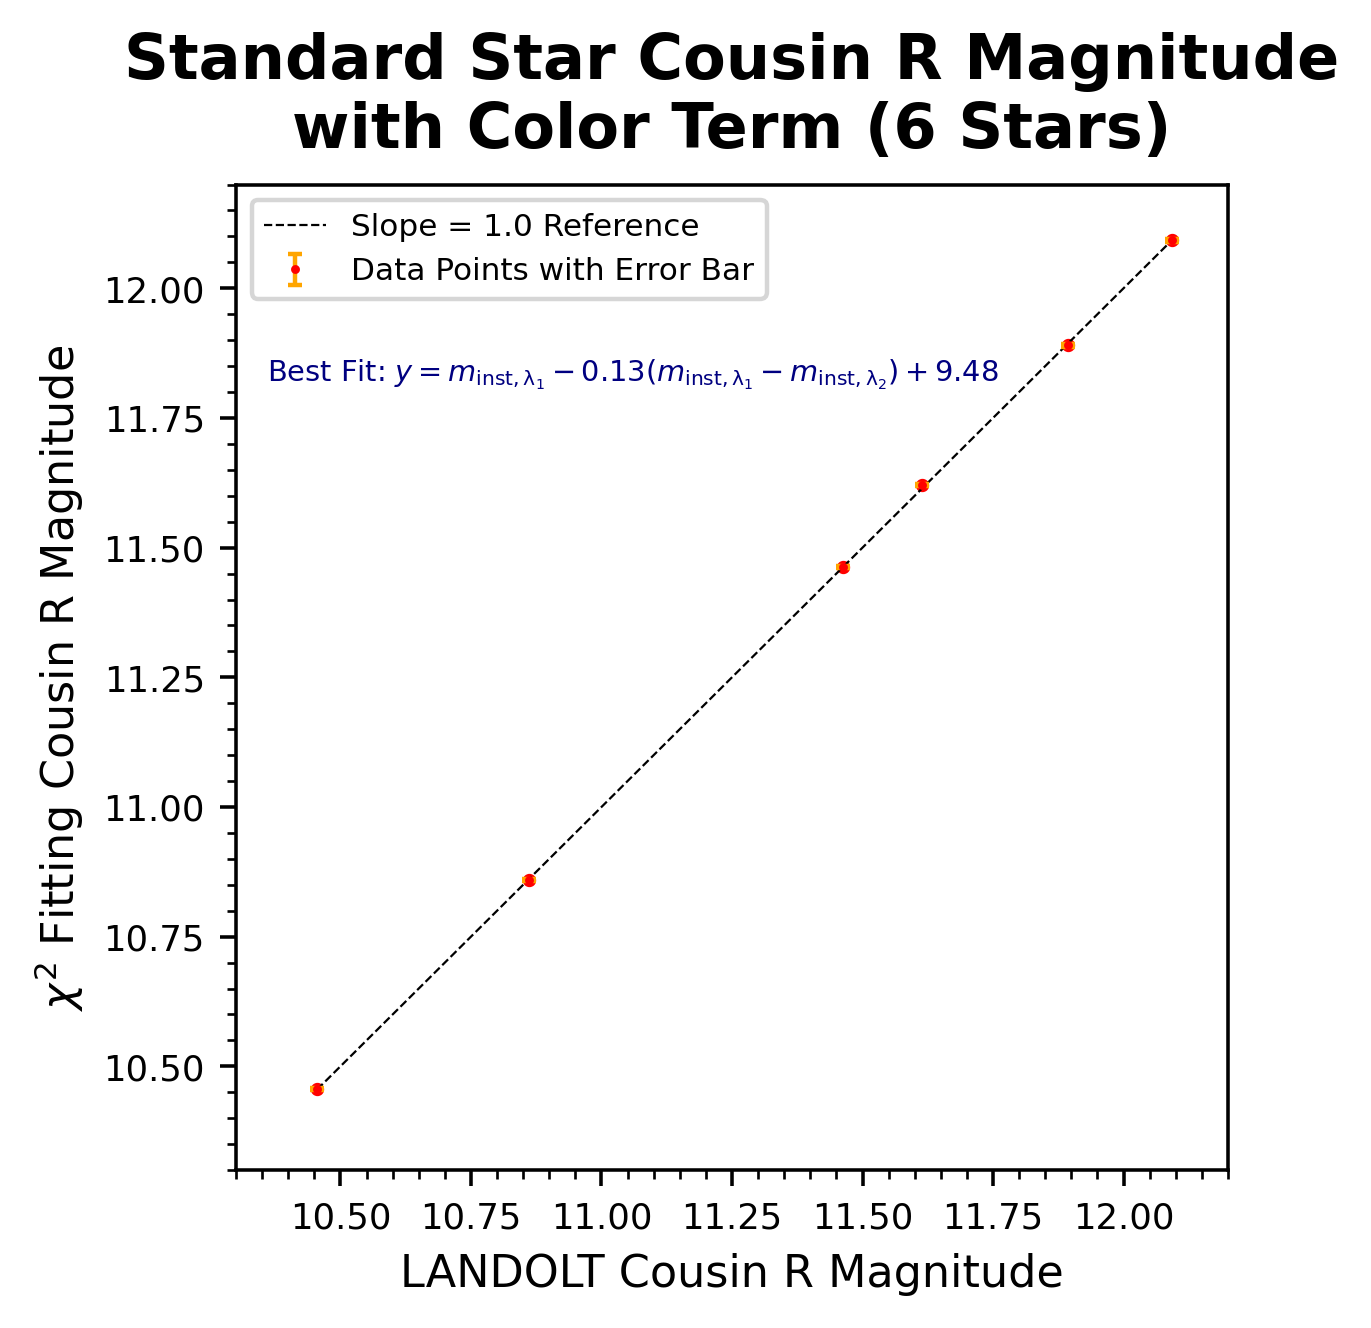

In [52]:
nan_filter              = (~cousin_R_landolt.isnull()).values  # some standard stars do not have Solan i values
magnitude_filter        = (cousin_R_landolt<=17.5)             # only choose bright enough sandard stars
combined_filter         = (nan_filter) & (magnitude_filter)
params_initial_guess    = [1.0, 1.0] # beta and gamma initial guess
error_weighting         = m_inst_R_error[combined_filter]
# error_weighting         = np.ones(combined_filter.sum())
fitobj                  = kmpfit.Fitter(residuals=residual_function, data=(m_inst_R[combined_filter].astype(np.float64), m_inst_I[combined_filter].astype(np.float64), cousin_R_landolt[combined_filter].values, error_weighting))
fitobj.fit(params0=params_initial_guess)

if (fitobj.status <= 0):
   print('error message =', fitobj.errmsg)
   raise RuntimeError("kmpfit failed!!")

beta_C_R, gamma_C_R             = fitobj.params[0], fitobj.params[1]
error_beta_C_R, error_gamma_C_R = fitobj.xerror[0], fitobj.xerror[1] # we use xerror (since the reduced chi square does not deviate from unit too much), so we don't use the stderr, which corresponding to the parameter error obtained by rescaling \sigma_i of each data point such that reduced chi square strictly equals to 1
# error_beta_C_R, error_gamma_C_R = fitobj.stderr[0], fitobj.stderr[1] # we use stderr (since the reduced chi square deviates from unit too much), which corresponding to the parameter error obtained by rescaling \sigma_i of each data point such that reduced chi square strictly equals to 1
reduced_chi_square      = fitobj.rchi2_min
print("Beta = %.3e ± %.3e; Gamma = %.3e ± %.3e "%(beta_C_R, error_beta_C_R, gamma_C_R, error_gamma_C_R))
print("Reduced chi_square = %.3e"%reduced_chi_square)


### plotting
dpi                 = 320
error_enlarge       = 1.0
fig                 = plt.figure(figsize=(4,4), dpi=dpi)
ax                  = plt.subplot(111)
band_filter         = "Cousin R"
save_suffix         = re.sub(" ", "_", band_filter)
save_suffix         = save_suffix[0].lower() + save_suffix[1:]
save_file_path      = "./photo_gallery"

m_inst_R_data       = m_inst_R[combined_filter]
m_inst_I_data       = m_inst_I[combined_filter]
m_inst_R_data_error = m_inst_R_error[combined_filter]
cousin_R_data        = cousin_R_landolt[combined_filter]
cousin_R_pred        = color_term_fitting(m_inst_lambda1=m_inst_R_data, m_inst_lambda2=m_inst_I_data, beta=beta_C_R, gamma=gamma_C_R)
x_range             = np.linspace(cousin_R_data.min(), cousin_R_data.max(), 128)

fitting_error_bar   = np.sqrt(m_inst_R_data_error**2.0 + fitobj.covar[0,0]*(m_inst_R_data-m_inst_I_data)**2. + (m_inst_R_data-m_inst_I_data)*(fitobj.covar[0,1]+fitobj.covar[1,0]) + fitobj.covar[1,1])

ax.plot(cousin_R_data, cousin_R_pred, color="red", marker="o", markersize=2.0, lw=0.0)
ax.plot(x_range, x_range, lw=0.5, ls="--", color="k", label="Slope = 1.0 Reference")
ax.errorbar(cousin_R_data, cousin_R_pred, fitting_error_bar,\
            lw=0.0, color='red', marker='o', markersize=1.0, capsize=1.5, mew=1.0, ls ='', label='Data Points with Error Bar', \
            ecolor='orange', elinewidth=1.0, barsabove=False)

ax.text(0.4, 0.80, "Best Fit: $y = m_{\\rm{inst},\lambda_1}%+.2f(m_{\\rm{inst},\lambda_1}-m_{\\rm{inst},\lambda_2})+%.2f$"%(beta_C_R,gamma_C_R), color="navy", fontsize=6.5, transform=ax.transAxes, horizontalalignment="center")

ax.set_xticks(np.arange(10.0, 12.3, 0.25))
ax.set_xticklabels(np.arange(10.0, 12.3, 0.25), fontsize=8.)
ax.set_yticks(np.arange(10.0, 12.3, 0.25))
ax.set_yticklabels(np.arange(10.0, 12.3, 0.25), fontsize=8.)
ax.set_xlim([10.3, 12.2])
ax.set_ylim([10.3, 12.2])

ax.set_xlabel("LANDOLT %s Magnitude"%(band_filter), fontsize=10.0)
ax.set_ylabel("$\chi^2$ Fitting %s Magnitude"%(band_filter), fontsize=10.0)

ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

ax.set_title("Standard Star %s Magnitude\nwith Color Term (%d Stars)"%(band_filter, combined_filter.sum()), y=1.01, fontsize=14., weight="bold")
ax.legend(loc="upper left", prop={"size": 7.0})

plt.savefig("%s/standard_star_%s_magnitude_chi_squre_fitting_with_color_term_%s.png"%(save_file_path,object_name,save_suffix), bbox_inches='tight', dpi=dpi, pad_inches=0.02, facecolor='white', transparent=True)
###

Beta = -2.792e-02 ± 2.901e-03; Gamma = 8.333e+00 ± 2.274e-03 
Reduced chi_square = 2.571e+01


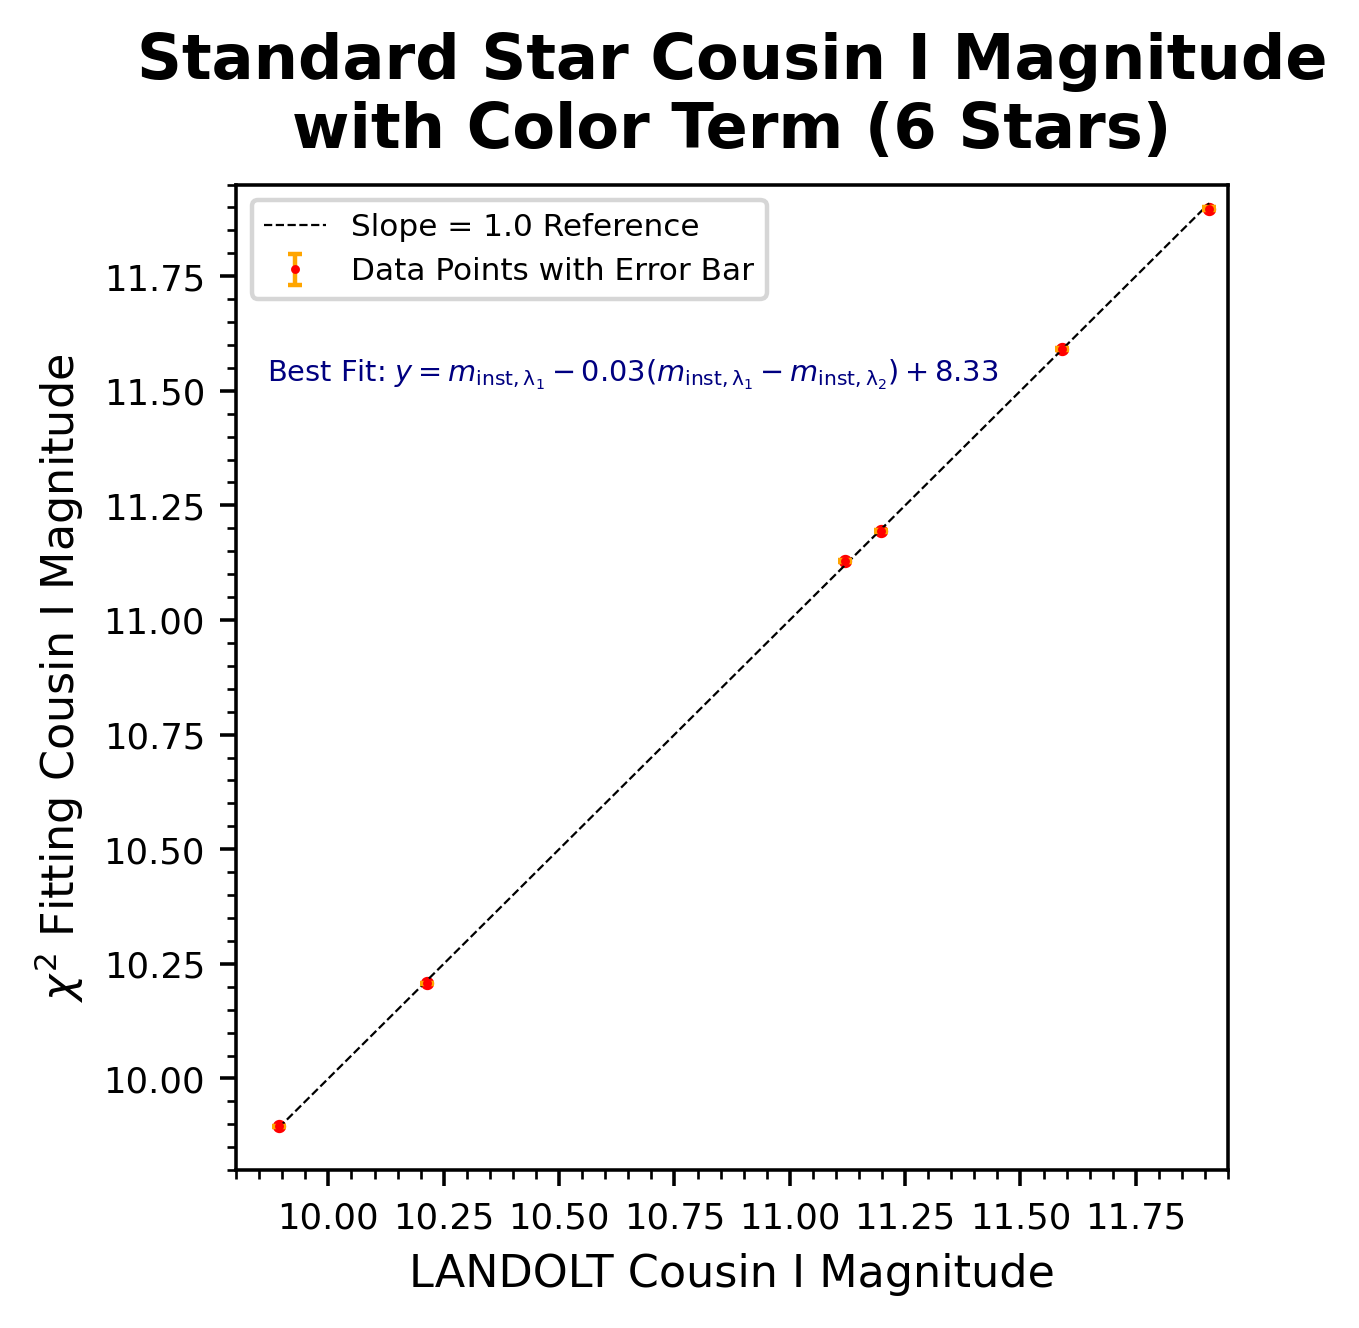

In [54]:
nan_filter              = (~cousin_I_landolt.isnull()).values  # some standard stars do not have Solan i values
magnitude_filter        = (cousin_I_landolt<=17.5)             # only choose bright enough sandard stars
combined_filter         = (nan_filter) & (magnitude_filter)
params_initial_guess    = [1.0, 1.0] # beta and gamma initial guess
error_weighting         = m_inst_I_error[combined_filter]
# error_weighting         = np.ones(combined_filter.sum())
fitobj                  = kmpfit.Fitter(residuals=residual_function, data=(m_inst_I[combined_filter].astype(np.float64), m_inst_R[combined_filter].astype(np.float64), cousin_I_landolt[combined_filter].values, error_weighting))
fitobj.fit(params0=params_initial_guess)

if (fitobj.status <= 0):
   print('error message =', fitobj.errmsg)
   raise RuntimeError("kmpfit failed!!")

beta_C_I, gamma_C_I             = fitobj.params[0], fitobj.params[1]
error_beta_C_I, error_gamma_C_I = fitobj.xerror[0], fitobj.xerror[1] # we use xerror (since the reduced chi square does not deviate from unit too much), so we don't use the stderr, which corresponding to the parameter error obtained by rescaling \sigma_i of each data point such that reduced chi square strictly equals to 1
# error_beta_C_I, error_gamma_C_I = fitobj.stderr[0], fitobj.stderr[1] # we use stderr (since the reduced chi square deviates from unit too much), which corresponding to the parameter error obtained by rescaling \sigma_i of each data point such that reduced chi square strictly equals to 1
reduced_chi_square      = fitobj.rchi2_min
print("Beta = %.3e ± %.3e; Gamma = %.3e ± %.3e "%(beta_C_I, error_beta_C_I, gamma_C_I, error_gamma_C_I))
print("Reduced chi_square = %.3e"%reduced_chi_square)


### plotting
dpi                 = 320
error_enlarge       = 1.0
fig                 = plt.figure(figsize=(4,4), dpi=dpi)
ax                  = plt.subplot(111)
band_filter         = "Cousin I"
save_suffix         = re.sub(" ", "_", band_filter)
save_suffix         = save_suffix[0].lower() + save_suffix[1:]
save_file_path      = "./photo_gallery"

m_inst_I_data       = m_inst_I[combined_filter]
m_inst_R_data       = m_inst_R[combined_filter]
m_inst_I_data_error = m_inst_I_error[combined_filter]
cousin_I_data       = cousin_I_landolt[combined_filter]
cousin_I_pred       = color_term_fitting(m_inst_lambda1=m_inst_I_data, m_inst_lambda2=m_inst_R_data, beta=beta_C_I, gamma=gamma_C_I)
x_range             = np.linspace(cousin_I_data.min(), cousin_I_data.max(), 128)

fitting_error_bar   = np.sqrt(m_inst_I_data_error**2.0 + fitobj.covar[0,0]*(m_inst_I_data-m_inst_R_data)**2. + (m_inst_I_data-m_inst_R_data)*(fitobj.covar[0,1]+fitobj.covar[1,0]) + fitobj.covar[1,1])

ax.plot(cousin_I_data, cousin_I_pred, color="red", marker="o", markersize=2.0, lw=0.0)
ax.plot(x_range, x_range, lw=0.5, ls="--", color="k", label="Slope = 1.0 Reference")
ax.errorbar(cousin_I_data, cousin_I_pred, fitting_error_bar,\
            lw=0.0, color='red', marker='o', markersize=1.0, capsize=1.5, mew=1.0, ls ='', label='Data Points with Error Bar', \
            ecolor='orange', elinewidth=1.0, barsabove=False)

ax.text(0.4, 0.80, "Best Fit: $y = m_{\\rm{inst},\lambda_1}%+.2f(m_{\\rm{inst},\lambda_1}-m_{\\rm{inst},\lambda_2})+%.2f$"%(beta_C_I,gamma_C_I), color="navy", fontsize=6.5, transform=ax.transAxes, horizontalalignment="center")

ax.set_xticks(np.arange(10.0, 12.3, 0.25))
ax.set_xticklabels(np.arange(10.0, 12.3, 0.25), fontsize=8.)
ax.set_yticks(np.arange(10.0, 12.3, 0.25))
ax.set_yticklabels(np.arange(10.0, 12.3, 0.25), fontsize=8.)
ax.set_xlim([9.8, 11.95])
ax.set_ylim([9.8, 11.95])

ax.set_xlabel("LANDOLT %s Magnitude"%(band_filter), fontsize=10.0)
ax.set_ylabel("$\chi^2$ Fitting %s Magnitude"%(band_filter), fontsize=10.0)

ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

ax.set_title("Standard Star %s Magnitude\nwith Color Term (%d Stars)"%(band_filter, combined_filter.sum()), y=1.01, fontsize=14., weight="bold")
ax.legend(loc="upper left", prop={"size": 7.0})

plt.savefig("%s/standard_star_%s_magnitude_chi_squre_fitting_with_color_term_%s.png"%(save_file_path,object_name,save_suffix), bbox_inches='tight', dpi=dpi, pad_inches=0.02, facecolor='white', transparent=True)
###